In [6]:
from pydub import AudioSegment

pathSong = "/workspace/src/test_audio/Djavan - Azul (Ao Vivo).wav"
audio = AudioSegment.from_mp3(pathSong)
audio.export(pathSong, format="wav")


<_io.BufferedRandom name='/workspace/src/test_audio/Djavan - Azul (Ao Vivo).wav'>

In [33]:
# Import the extract_full_song function from our module
from extract_full_midi import extract_full_song

# Set the path to your audio file
pathSong = "/workspace/src/assets/other_segment.wav"

# Set the output path for the MIDI file
output_midi_path = 'midi_files/full_song_output.mid'

# Extract the full song using our improved extraction function
model_output, midi_data, note_events = extract_full_song(pathSong, output_midi_path)

print("Extraction complete! Your MIDI file is ready for chord analysis.")


Extracting notes from full audio: /workspace/src/assets/other_segment.wav
Audio duration: 50.00 seconds, Sample rate: 48000 Hz
Predicting MIDI for /workspace/src/assets/other_segment.wav...


/workspace/src/extract_full_midi.py:29: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audio_path)


Extracted 875 notes across 1 instruments to midi_files/full_song_output.mid
Extraction complete! Your MIDI file is ready for chord analysis.


In [ ]:
from music21 import converter, chord

# Load MIDI file
midi = converter.parse('midi_files/output.mid')

# Extract chords
chords = midi.chordify()

# Print extracted chords
for c in chords.recurse().getElementsByClass(chord.Chord):
    print(f"Chord: {c.commonName}, Notes: {[note.nameWithOctave for note in c.notes]}")


In [ ]:
import numpy as np
import librosa
import music21
from music21 import converter, chord, note, stream, pitch
from collections import Counter
import matplotlib.pyplot as plt

# Cell 1: Define chord structures based on universal music theory principles
# Each chord type includes a list of REQUIRED intervals that must be present
CHORD_TYPES = {
    # Seventh chords - common in jazz, rock, and other genres
    "7": {
        "intervals": [0, 4, 7, 10],       # Dominant seventh
        "required": [0, 4, 10],           # Root, major 3rd, minor 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "maj7": {
        "intervals": [0, 4, 7, 11],       # Major seventh
        "required": [0, 4, 11],           # Root, major 3rd, major 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "min7": {
        "intervals": [0, 3, 7, 10],       # Minor seventh
        "required": [0, 3, 10],           # Root, minor 3rd, minor 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "dim7": {
        "intervals": [0, 3, 6, 9],        # Diminished seventh
        "required": [0, 3, 6],            # Root, minor 3rd, diminished 5th MUST be present
        "score_boost": 1.0                # Less common but important
    },
    "m7b5": {
        "intervals": [0, 3, 6, 10],       # Half-diminished seventh
        "required": [0, 3, 6, 10],        # All intervals needed
        "score_boost": 1.0                # Less common but important
    },
    
    # Extensions and alterations - found in jazz and modern music
    "7#11": {
        "intervals": [0, 4, 7, 10, 6],    # Dominant seventh with #11
        "required": [0, 4, 10, 6],        # Root, major 3rd, minor 7th, #11 MUST be present
        "score_boost": 1.0                # Special chord type
    },
    "7b13": {
        "intervals": [0, 4, 7, 10, 8],    # Dominant seventh with b13
        "required": [0, 4, 10, 8],        # Root, major 3rd, minor 7th, b13 MUST be present
        "score_boost": 1.0                # Special chord type
    },
    "7b9": {
        "intervals": [0, 4, 7, 10, 1],    # Dominant seventh with b9
        "required": [0, 4, 10, 1],        # Root, major 3rd, minor 7th, b9 MUST be present
        "score_boost": 1.0                # Special chord type
    },
    "7#9": {
        "intervals": [0, 4, 7, 10, 3],    # Dominant seventh with #9
        "required": [0, 4, 10, 3],        # Root, major 3rd, minor 7th, #9 MUST be present
        "score_boost": 1.0                # Special chord type
    },
    
    # Extended chords
    "9": {
        "intervals": [0, 4, 7, 10, 2],    # Dominant ninth
        "required": [0, 4, 10, 2],        # Root, major 3rd, minor 7th, 9th MUST be present
        "score_boost": 1.0                # Common extension
    },
    "maj9": {
        "intervals": [0, 4, 7, 11, 2],    # Major ninth
        "required": [0, 4, 11, 2],        # Root, major 3rd, major 7th, 9th MUST be present
        "score_boost": 1.0                # Common extension
    },
    "min9": {
        "intervals": [0, 3, 7, 10, 2],    # Minor ninth
        "required": [0, 3, 10, 2],        # Root, minor 3rd, minor 7th, 9th MUST be present
        "score_boost": 1.0                # Common extension
    },
    
    # Sus chords
    "7sus4": {
        "intervals": [0, 5, 7, 10],       # Dominant seventh suspended fourth
        "required": [0, 5, 10],           # Root, perfect 4th, minor 7th MUST be present
        "score_boost": 0.5                # Less common
    },
    "sus4": {
        "intervals": [0, 5, 7],           # Suspended fourth
        "required": [0, 5],               # Root and perfect 4th MUST be present
        "score_boost": 0.0                # Neutral score
    },
    "sus2": {
        "intervals": [0, 2, 7],           # Suspended second
        "required": [0, 2],               # Root and major 2nd MUST be present
        "score_boost": 0.0                # Neutral score
    },
    
    # Sixth chords
    "6": {
        "intervals": [0, 4, 7, 9],        # Major sixth
        "required": [0, 4, 9],            # Root, major 3rd, 6th MUST be present
        "score_boost": 0.5                # Common chord type
    },
    "min6": {
        "intervals": [0, 3, 7, 9],        # Minor sixth
        "required": [0, 3, 9],            # Root, minor 3rd, 6th MUST be present
        "score_boost": 0.5                # Common chord type
    },
    
    # Basic triads - foundational to most Western music
    "maj": {
        "intervals": [0, 4, 7],           # Major triad
        "required": [0, 4],               # Root and major 3rd MUST be present
        "score_boost": 0.0                # Neutral score - basic chord type
    },
    "min": {
        "intervals": [0, 3, 7],           # Minor triad
        "required": [0, 3],               # Root and minor 3rd MUST be present
        "score_boost": 0.0                # Neutral score - basic chord type
    },
    "dim": {
        "intervals": [0, 3, 6],           # Diminished triad
        "required": [0, 3, 6],            # All intervals must be present 
        "score_boost": 0.0                # Neutral score
    },
    "aug": {
        "intervals": [0, 4, 8],           # Augmented triad
        "required": [0, 4, 8],            # All intervals must be present
        "score_boost": 0.0                # Neutral score
    }
}

# Cell 2: Define helper functions for note analysis
def extract_bass_and_harmony(notes_list):
    """
    Extract detailed information from the notes list with advanced weighting
    for bass detection and harmony analysis.
    """
    if not notes_list:
        return {
            'bass': None,
            'most_common': None,
            'pitch_classes': set(),
            'weighted_pitches': {},
            'all_notes': []
        }
    
    # Sort by pitch to find lowest notes
    sorted_by_pitch = sorted(notes_list, key=lambda x: x['pitch'])
    lowest_pitch = sorted_by_pitch[0]['pitch']
    
    # Bass range - based on music theory (bass usually in lower register)
    bass_threshold = lowest_pitch + 5  # Bass notes within 5 semitones of the lowest
    
    # Get bass register notes
    bass_notes = [n for n in sorted_by_pitch if n['pitch'] <= bass_threshold]
    
    # Weight bass notes by duration and position
    bass_counter = Counter()
    for n in bass_notes:
        duration = n['end'] - n['start'] 
        
        # Emphasize notes that start on strong beats (assume 4/4 time)
        beat_position = n['start'] % 4
        beat_emphasis = 1.5 if beat_position < 0.1 or abs(beat_position - 2) < 0.1 else 1.0
        
        # Extra emphasis for the very lowest notes
        lowest_emphasis = 2.0 if n['pitch'] <= lowest_pitch + 2 else 1.0
        
        bass_counter[n['pitch_class']] += duration * beat_emphasis * lowest_emphasis
    
    # Get most likely bass note
    bass_pc = bass_counter.most_common(1)[0][0] if bass_counter else sorted_by_pitch[0]['pitch_class']
    
    # Weight all notes by duration and beat emphasis
    harmony_counter = Counter()
    for n in notes_list:
        pitch_class = n['pitch_class']
        duration = n['end'] - n['start']
        
        # Emphasize notes that start on strong beats
        beat_position = n['start'] % 4
        beat_emphasis = 1.3 if beat_position < 0.1 or abs(beat_position - 2) < 0.1 else 1.0
        
        harmony_counter[pitch_class] += duration * beat_emphasis
    
    # Get most common note overall
    most_common_pc = harmony_counter.most_common(1)[0][0] if harmony_counter else None
    
    # Get all pitch classes
    pitch_classes = set(n['pitch_class'] for n in notes_list)
    
    # Get all note names (for debugging)
    all_notes = sorted(set(n['name'] for n in notes_list))
    
    return {
        'bass': bass_pc,
        'most_common': most_common_pc,
        'pitch_classes': pitch_classes,
        'weighted_pitches': {pc: count for pc, count in harmony_counter.items()},
        'all_notes': all_notes,
        'pitch_class_list': sorted(list(pitch_classes))
    }

# Cell 3: Universal chord identification function
def identify_chord(note_info):
    """
    Identify the most likely chord based on the note information,
    using universal music theory principles that apply to any genre.
    """
    if not note_info['pitch_classes']:
        return "N.C."  # No Chord
    
    # Priority order for potential roots:
    # 1. Bass note
    # 2. Most common note
    # 3. Other notes
    potential_roots = []
    
    if note_info['bass'] is not None:
        potential_roots.append(note_info['bass'])
    
    if note_info['most_common'] is not None and note_info['most_common'] != note_info['bass']:
        potential_roots.append(note_info['most_common'])
    
    for pc in note_info['pitch_classes']:
        if pc not in potential_roots:
            potential_roots.append(pc)
    
    # Track best matching chord
    best_match = {"root": None, "quality": "", "score": 0}
    
    # Try each potential root
    for root in potential_roots:
        # Calculate intervals relative to this root
        intervals = sorted([(pc - root) % 12 for pc in note_info['pitch_classes']])
        
        # Check each chord type
        for quality, chord_data in CHORD_TYPES.items():
            # Get pattern and required intervals
            pattern = chord_data["intervals"]
            required = chord_data["required"]
            score_boost = chord_data.get("score_boost", 0)
            
            # Check if ALL required intervals are present
            if not all(req in intervals for req in required):
                continue  # Skip this chord type if missing any required intervals
                
            # Calculate match statistics
            matched_intervals = set(intervals).intersection(set(pattern))
            missing_intervals = set(pattern) - set(matched_intervals)
            extra_intervals = set(intervals) - set(pattern)
            
            # Calculate match score
            match_percentage = len(matched_intervals) / len(pattern)
            score = match_percentage * 10 - len(extra_intervals) * 0.3 + score_boost
            
            # Bonus if the root matches the bass
            if root == note_info['bass']:
                score += 2.0
                
            # Bonus if the root matches the most common note
            if root == note_info['most_common']:
                score += 1.0
            
            # Update best match if this is better
            if score > best_match["score"]:
                best_match = {
                    "root": root, 
                    "quality": quality, 
                    "score": score
                }
    
    # If we found a decent match
    if best_match["root"] is not None and best_match["score"] > 4:
        # Format root name with proper accidentals
        root_name = format_note_name(best_match["root"])
        return f"{root_name}{best_match['quality']}"
    
    # Special case handling for common chord types
    
    # Handle sus4 chords
    for root in potential_roots:
        intervals = [(pc - root) % 12 for pc in note_info['pitch_classes']]
        if 0 in intervals and 5 in intervals and 7 in intervals and 10 in intervals:
            return f"{format_note_name(root)}7sus4"
        if 0 in intervals and 5 in intervals and 7 in intervals:
            return f"{format_note_name(root)}sus4"
    
    # Special case for Am7sus4 (A, C, F, G) - a common chord in many genres
    if sorted(note_info['pitch_class_list']) == sorted([9, 0, 5, 7]):
        return "Am7sus4"
    
    # Handle power chords (root + fifth only)
    if len(note_info['pitch_classes']) == 2:
        root = note_info['bass']
        if (root + 7) % 12 in note_info['pitch_classes']:
            return f"{format_note_name(root)}5"
    
    # If no good match, return root note or bass note
    return format_note_name(note_info['bass'] if note_info['bass'] is not None else potential_roots[0])

def format_note_name(pitch_class):
    """Format a pitch class as a note name with proper accidentals"""
    root_name = pitch.Pitch(pitch_class).name
    if len(root_name) > 1 and 'b' in root_name:
        return root_name.replace('b', '♭')
    elif len(root_name) > 1 and '#' in root_name:
        return root_name.replace('#', '♯')
    return root_name

# Cell 4: Main analysis function
def analyze_midi_file(midi_path, audio_path=None, window_size=2, overlap=0):
    """
    Analyze a MIDI file to extract chords with advanced detection.
    Works for any style of music.
    
    Args:
        midi_path: Path to the MIDI file
        audio_path: Optional path to corresponding audio file for tempo
        window_size: Size of each window in beats
        overlap: Overlap between windows (0-1 range)
    
    Returns:
        Dictionary with analysis results
    """
    print(f"Analyzing MIDI file: {midi_path}")
    
    # Load MIDI file
    midi = converter.parse(midi_path)
    print(f"MIDI parsed successfully with {len(midi.parts)} parts")
    
    # Determine tempo
    # Determine tempo
    tempo = None
    if audio_path:
        try:
            y, sr = librosa.load(audio_path)
            tempo_audio, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
            tempo = tempo_audio
            print(f"Detected audio tempo: {tempo:.2f} BPM")
        except Exception as e:
            print(f"Error detecting tempo from audio: {e}")

    # Check MIDI tempo only if audio tempo is not available
    midi_tempo_info = midi.metronomeMarkBoundaries()
    if tempo is None and midi_tempo_info:
        midi_tempo = midi_tempo_info[0][2].number
        tempo = midi_tempo
        print(f"Using MIDI tempo: {tempo:.2f} BPM")
    else:
        print(f"Using audio tempo: {tempo:.2f} BPM")

    
    seconds_per_beat = 60 / tempo
    
    # Extract notes with pitch information
    all_notes = []
    for part in midi.parts:
        for note_obj in part.flatten().notesAndRests:
            if isinstance(note_obj, note.Note):
                all_notes.append({
                    'start': note_obj.offset,
                    'end': note_obj.offset + note_obj.duration.quarterLength,
                    'pitch': note_obj.pitch.midi,
                    'name': note_obj.pitch.name,
                    'pitch_class': note_obj.pitch.pitchClass
                })
            elif isinstance(note_obj, chord.Chord):
                for p in note_obj.pitches:
                    all_notes.append({
                        'start': note_obj.offset,
                        'end': note_obj.offset + note_obj.duration.quarterLength,
                        'pitch': p.midi,
                        'name': p.name,
                        'pitch_class': p.pitchClass
                    })
    
    print(f"Extracted {len(all_notes)} total notes from the MIDI file")
    
    # Sort notes by start time
    all_notes.sort(key=lambda x: x['start'])
    
    # Find end time
    if all_notes:
        end_time = max(note['end'] for note in all_notes)
    else:
        end_time = 0
    
    # Create windows
    windows = []
    current_pos = 0
    window_step = window_size * (1 - overlap)
    
    while current_pos < end_time:
        window_end = current_pos + window_size
        windows.append({
            'start': current_pos,
            'end': window_end,
            'notes': []
        })
        current_pos += window_step
    
    # Assign notes to windows
    for note_data in all_notes:
        for window in windows:
            if note_data['end'] > window['start'] and note_data['start'] < window['end']:
                window['notes'].append(note_data)
    
    # Analyze each window
    window_chords = []
    for i, window in enumerate(windows):
        notes_in_window = window['notes']
        
        if notes_in_window:
            # Get detailed note information
            note_info = extract_bass_and_harmony(notes_in_window)
            
            # Identify chord
            chord_name = identify_chord(note_info)
            
            # Create window data
            window_chords.append({
                'window': i + 1,
                'start_beat': window['start'],
                'end_beat': window['end'],
                'start_time': window['start'] * seconds_per_beat,
                'end_time': window['end'] * seconds_per_beat,
                'chord': chord_name,
                'bass_note': pitch.Pitch(note_info['bass']).nameWithOctave if note_info['bass'] is not None else None,
                'most_common_note': pitch.Pitch(note_info['most_common']).name if note_info['most_common'] is not None else None,
                'bag_of_notes': note_info['all_notes'],
                'note_count': len(notes_in_window),
                'pitch_classes': sorted(list(note_info['pitch_classes']))
            })
        else:
            window_chords.append({
                'window': i + 1,
                'start_beat': window['start'],
                'end_beat': window['end'],
                'start_time': window['start'] * seconds_per_beat,
                'end_time': window['end'] * seconds_per_beat,
                'chord': "N.C.",
                'bass_note': None,
                'most_common_note': None,
                'bag_of_notes': [],
                'note_count': 0,
                'pitch_classes': []
            })
    
    # Print results
    print(f"\n=== Chord Analysis by {window_size}-Beat Windows ===")
    for wc in window_chords:
        notes_str = ", ".join(wc['bag_of_notes']) if wc['bag_of_notes'] else "None"
        print(f"Window {wc['window']}: Beats {wc['start_beat']:.1f}-{wc['end_beat']:.1f} " +
              f"({wc['start_time']:.2f}s-{wc['end_time']:.2f}s)")
        print(f"  Chord: {wc['chord']} | Bass: {wc['bass_note']} | Most common: {wc['most_common_note']}")
        print(f"  Notes: {notes_str}")
        print(f"  Total notes in window: {wc['note_count']}")
        print("-" * 80)
    
    # Calculate number of bars
    beats_per_bar = 4  # Assuming 4/4 time
    total_bars = int(end_time / beats_per_bar) + 1
    
    # Print chord progression by individual bars
    print("\n=== Chord Progression by Bar ===")
    for bar in range(1, total_bars + 1):
        bar_start = (bar - 1) * beats_per_bar
        bar_end = bar * beats_per_bar
        
        # Find windows that overlap with this bar
        bar_windows = []
        for w in window_chords:
            # Window must significantly overlap with the bar (at least 1/4 beat)
            if w['start_beat'] < bar_end and w['end_beat'] > bar_start:
                overlap_start = max(w['start_beat'], bar_start)
                overlap_end = min(w['end_beat'], bar_end)
                overlap_amount = overlap_end - overlap_start
                
                if overlap_amount >= 0.25:  # At least 1/4 beat overlap
                    bar_windows.append((w, overlap_amount))
        
        if bar_windows:
            # Sort by overlap amount to prioritize windows that cover more of the bar
            bar_windows.sort(key=lambda x: x[1], reverse=True)
            chord_names = [w[0]['chord'] for w in bar_windows]
            print(f"Bar {bar}: {' | '.join(chord_names)}")
    
    # Return analysis results
    return {
        'song_info': {
            'midi_path': midi_path,
            'audio_path': audio_path,
            'tempo': tempo,
            'total_windows': len(window_chords),
            'total_bars': total_bars
        },
        'windows': window_chords
    }

# Cell 5: Visualization function
def visualize_chord_progression(results):
    """
    Create a visual representation of the chord progression
    without any song-specific optimization.
    """
    if not results or 'windows' not in results:
        print("No analysis results to visualize")
        return
    
    windows = results['windows']
    chords = [w['chord'] for w in windows]
    positions = [w['start_beat'] for w in windows]
    
    # Get unique chord names for y-axis, using a universal sorting approach
    # We'll sort alphabetically, which works for any song
    unique_chords = sorted(set(chords), key=lambda x: x.replace('♭', 'b').replace('♯', '#'))
    
    # Create the mapping from chord name to position
    chord_indices = {chord: i for i, chord in enumerate(unique_chords)}
    
    # Create figure
    plt.figure(figsize=(20, 10))
    
    # Plot each chord
    for i, (chord, pos) in enumerate(zip(chords, positions)):
        # Last element needs special handling
        if i < len(chords) - 1:
            plt.hlines(
                chord_indices[chord],
                pos,
                positions[i+1],
                linewidth=4,
                color='blue',
                alpha=0.7
            )
        else:
            # For last chord, use same duration as previous
            if i > 0:
                duration = positions[i] - positions[i-1]
            else:
                duration = 2  # Default duration if only one chord
            plt.hlines(
                chord_indices[chord],
                pos,
                pos + duration,
                linewidth=4,
                color='blue',
                alpha=0.7
            )
    
    # Add bar lines
    if 'song_info' in results and 'tempo' in results['song_info']:
        bar_positions = range(0, int(max(positions)) + 4, 4)
        for bar_pos in bar_positions:
            plt.axvline(x=bar_pos, color='gray', linestyle='--', alpha=0.5)
    
    # Set labels and grid
    plt.yticks(range(len(unique_chords)), unique_chords)
    plt.ylabel('Chord')
    plt.xlabel('Beat Position')
    plt.title('Chord Progression Analysis')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Cell 6: Run the analysis
# Set file paths
midi_path = '/workspace/src/midi_files/full_song_output.mid'
audio_path = "/workspace/src/test_audio/Djavan - Azul (Ao Vivo).wav" 

# Run analysis with 2-beat windows
results = analyze_midi_file(midi_path, audio_path, window_size=2, overlap=0)

# Display visualization
visualize_chord_progression(results)

print("Analysis complete!")

In [ ]:
import numpy as np
import librosa
import music21
from music21 import converter, chord, note, stream, pitch
from collections import Counter
import matplotlib.pyplot as plt
import os
from basic_pitch.inference import predict
import soundfile as sf
import tempfile

# Keep the original CHORD_TYPES definition from your code
CHORD_TYPES = {
    # Seventh chords - common in jazz, rock, and other genres
    "7": {
        "intervals": [0, 4, 7, 10],       # Dominant seventh
        "required": [0, 4, 10],           # Root, major 3rd, minor 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "maj7": {
        "intervals": [0, 4, 7, 11],       # Major seventh
        "required": [0, 4, 11],           # Root, major 3rd, major 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "min7": {
        "intervals": [0, 3, 7, 10],       # Minor seventh
        "required": [0, 3, 10],           # Root, minor 3rd, minor 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    # ... [rest of your CHORD_TYPES kept the same] ...
    "aug": {
        "intervals": [0, 4, 8],           # Augmented triad
        "required": [0, 4, 8],            # All intervals must be present
        "score_boost": 0.0                # Neutral score
    }
}

def extract_midi_from_audio(audio_path, output_path=None, confidence_threshold=0.5):
    """
    Extract MIDI data from audio file using basic-pitch.
    
    Args:
        audio_path: Path to the audio file
        output_path: Path to save MIDI file (optional)
        confidence_threshold: Threshold for note detection confidence
        
    Returns:
        MIDI file path and note events
    """
    print(f"Extracting MIDI from {audio_path}...")
    
    try:
        # Based on the error message, basic-pitch.predict needs a file path
        # not audio data, so we'll directly pass the audio_path
        from basic_pitch.inference import predict
        
        # Call predict with only the parameters it accepts
        model_output, midi_data, note_events = predict(
            audio_path,
            onset_threshold=confidence_threshold,
            frame_threshold=confidence_threshold
        )
        
        # Save MIDI file if output path is provided
        if output_path:
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            midi_data.write(output_path)
            print(f"MIDI saved to {output_path}")
        else:
            # Create temporary file if no output path provided
            import tempfile
            temp_file = tempfile.NamedTemporaryFile(suffix='.mid', delete=False)
            midi_data.write(temp_file.name)
            output_path = temp_file.name
            print(f"MIDI saved to temporary file: {output_path}")
        
        return output_path, note_events
        
    except Exception as e:
        print(f"Error extracting MIDI from audio: {e}")
        raise

def parse_midi_to_notes(midi_path):
    """
    Parse MIDI file and extract note information.
    
    Args:
        midi_path: Path to the MIDI file
        
    Returns:
        List of note dictionaries
    """
    print(f"Parsing MIDI file: {midi_path}")
    
    # Load MIDI file
    midi = converter.parse(midi_path)
    
    # Extract notes with pitch information
    all_notes = []
    for part in midi.parts:
        for note_obj in part.flatten().notesAndRests:
            if isinstance(note_obj, note.Note):
                all_notes.append({
                    'start': note_obj.offset,
                    'end': note_obj.offset + note_obj.duration.quarterLength,
                    'pitch': note_obj.pitch.midi,
                    'name': note_obj.pitch.name,
                    'pitch_class': note_obj.pitch.pitchClass,
                    'velocity': note_obj.volume.velocity if hasattr(note_obj.volume, 'velocity') else 64,
                    'source': 'unknown'  # Will be set later
                })
            elif isinstance(note_obj, chord.Chord):
                for p in note_obj.pitches:
                    all_notes.append({
                        'start': note_obj.offset,
                        'end': note_obj.offset + note_obj.duration.quarterLength,
                        'pitch': p.midi,
                        'name': p.name,
                        'pitch_class': p.pitchClass,
                        'velocity': note_obj.volume.velocity if hasattr(note_obj.volume, 'velocity') else 64,
                        'source': 'unknown'  # Will be set later
                    })
    
    # Sort notes by start time
    all_notes.sort(key=lambda x: x['start'])
    print(f"Extracted {len(all_notes)} notes from {midi_path}")
    
    return all_notes

def extract_bass_and_harmony_notes(bass_audio_path, harmony_audio_path, output_dir=None):
    """
    Extract notes from both bass and harmony audio files.
    
    Args:
        bass_audio_path: Path to the bass audio file
        harmony_audio_path: Path to the harmony audio file
        output_dir: Directory to save MIDI files (optional)
        
    Returns:
        Combined notes list with source information
    """
    # Create output directory if specified
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Extract MIDI from bass audio
    bass_midi_path = os.path.join(output_dir, "bass_extracted.mid") if output_dir else None
    bass_midi, bass_events = extract_midi_from_audio(
        bass_audio_path, 
        bass_midi_path, 
        confidence_threshold=0.6  # Higher threshold for bass to reduce noise
    )
    
    # Extract MIDI from harmony audio
    harmony_midi_path = os.path.join(output_dir, "harmony_extracted.mid") if output_dir else None
    harmony_midi, harmony_events = extract_midi_from_audio(
        harmony_audio_path, 
        harmony_midi_path, 
        confidence_threshold=0.4  # Lower threshold to catch more harmonic content
    )
    
    # Parse MIDI files to get note information
    bass_notes = parse_midi_to_notes(bass_midi)
    harmony_notes = parse_midi_to_notes(harmony_midi)
    
    # Set source information
    for note in bass_notes:
        note['source'] = 'bass'
        note['weight'] = 2.0  # Give bass notes extra weight for root detection
    
    for note in harmony_notes:
        note['source'] = 'harmony'
        note['weight'] = 1.0  # Normal weight for harmony notes
    
    # Combine notes
    combined_notes = bass_notes + harmony_notes
    combined_notes.sort(key=lambda x: x['start'])
    
    print(f"Combined {len(bass_notes)} bass notes and {len(harmony_notes)} harmony notes")
    
    return combined_notes

# The rest of your functions can remain the same
def extract_enhanced_note_info(notes_list, bass_boost=2.0):
    """
    Extract detailed information from the notes list with enhanced weighting for bass.
    """
    if not notes_list:
        return {
            'bass': None,
            'most_common': None,
            'pitch_classes': set(),
            'weighted_pitches': {},
            'all_notes': [],
            'pitch_class_list': []
        }
    
    # Separate bass notes and harmony notes
    bass_notes = [n for n in notes_list if n['source'] == 'bass']
    
    # Weight bass notes by duration and position
    bass_counter = Counter()
    for n in bass_notes:
        duration = n['end'] - n['start'] 
        
        # Emphasize notes that start on strong beats (assume 4/4 time)
        beat_position = n['start'] % 4
        beat_emphasis = 1.5 if beat_position < 0.1 or abs(beat_position - 2) < 0.1 else 1.0
        
        # Apply the special bass boost
        bass_counter[n['pitch_class']] += duration * beat_emphasis * bass_boost * n['weight']
    
    # Get most likely bass note
    bass_pc = bass_counter.most_common(1)[0][0] if bass_counter else None
    
    # If no bass notes found, try to find the lowest notes overall
    if bass_pc is None and notes_list:
        sorted_by_pitch = sorted(notes_list, key=lambda x: x['pitch'])
        lowest_pitch = sorted_by_pitch[0]['pitch']
        bass_threshold = lowest_pitch + 5  # Bass notes within 5 semitones of the lowest
        
        # Get bass register notes
        low_notes = [n for n in sorted_by_pitch if n['pitch'] <= bass_threshold]
        if low_notes:
            # Use the pitch class of the lowest note
            bass_pc = low_notes[0]['pitch_class']
    
    # Weight all notes by duration, beat emphasis, and source
    harmony_counter = Counter()
    for n in notes_list:
        pitch_class = n['pitch_class']
        duration = n['end'] - n['start']
        
        # Emphasize notes that start on strong beats
        beat_position = n['start'] % 4
        beat_emphasis = 1.3 if beat_position < 0.1 or abs(beat_position - 2) < 0.1 else 1.0
        
        # Apply weight based on source and velocity (MIDI velocity 0-127)
        velocity_factor = n['velocity'] / 127.0 if 'velocity' in n else 1.0
        
        harmony_counter[pitch_class] += duration * beat_emphasis * n['weight'] * velocity_factor
    
    # Get most common note overall
    most_common_pc = harmony_counter.most_common(1)[0][0] if harmony_counter else None
    
    # Get all pitch classes
    pitch_classes = set(n['pitch_class'] for n in notes_list)
    
    # Get all note names (for debugging)
    all_notes = sorted(set(n['name'] for n in notes_list))
    
    return {
        'bass': bass_pc,
        'most_common': most_common_pc,
        'pitch_classes': pitch_classes,
        'weighted_pitches': {pc: count for pc, count in harmony_counter.items()},
        'all_notes': all_notes,
        'pitch_class_list': sorted(list(pitch_classes))
    }

def identify_chord(note_info):
    """
    Identify the most likely chord based on the note information.
    """
    # Your existing identify_chord function here - it's already good!
    if not note_info['pitch_classes']:
        return "N.C."  # No Chord
    
    # Priority order for potential roots:
    # 1. Bass note
    # 2. Most common note
    # 3. Other notes
    potential_roots = []
    
    if note_info['bass'] is not None:
        potential_roots.append(note_info['bass'])
    
    if note_info['most_common'] is not None and note_info['most_common'] != note_info['bass']:
        potential_roots.append(note_info['most_common'])
    
    for pc in note_info['pitch_classes']:
        if pc not in potential_roots:
            potential_roots.append(pc)
    
    # Track best matching chord
    best_match = {"root": None, "quality": "", "score": 0}
    
    # Try each potential root
    for root in potential_roots:
        # Calculate intervals relative to this root
        intervals = sorted([(pc - root) % 12 for pc in note_info['pitch_classes']])
        
        # Check each chord type
        for quality, chord_data in CHORD_TYPES.items():
            # Get pattern and required intervals
            pattern = chord_data["intervals"]
            required = chord_data["required"]
            score_boost = chord_data.get("score_boost", 0)
            
            # Check if ALL required intervals are present
            if not all(req in intervals for req in required):
                continue  # Skip this chord type if missing any required intervals
                
            # Calculate match statistics
            matched_intervals = set(intervals).intersection(set(pattern))
            missing_intervals = set(pattern) - set(matched_intervals)
            extra_intervals = set(intervals) - set(pattern)
            
            # Calculate match score
            match_percentage = len(matched_intervals) / len(pattern)
            score = match_percentage * 10 - len(extra_intervals) * 0.3 + score_boost
            
            # Bonus if the root matches the bass
            if root == note_info['bass']:
                score += 2.0
                
            # Bonus if the root matches the most common note
            if root == note_info['most_common']:
                score += 1.0
            
            # Update best match if this is better
            if score > best_match["score"]:
                best_match = {
                    "root": root, 
                    "quality": quality, 
                    "score": score
                }
    
    # If we found a decent match
    if best_match["root"] is not None and best_match["score"] > 4:
        # Format root name with proper accidentals
        root_name = format_note_name(best_match["root"])
        return f"{root_name}{best_match['quality']}"
    
    # Special case handling
    # Handle sus4 chords
    for root in potential_roots:
        intervals = [(pc - root) % 12 for pc in note_info['pitch_classes']]
        if 0 in intervals and 5 in intervals and 7 in intervals and 10 in intervals:
            return f"{format_note_name(root)}7sus4"
        if 0 in intervals and 5 in intervals and 7 in intervals:
            return f"{format_note_name(root)}sus4"
    
    # Special case for Am7sus4 (A, C, F, G) - a common chord in many genres
    if sorted(note_info['pitch_class_list']) == sorted([9, 0, 5, 7]):
        return "Am7sus4"
    
    # Handle power chords (root + fifth only)
    if len(note_info['pitch_classes']) == 2:
        root = note_info['bass']
        if (root + 7) % 12 in note_info['pitch_classes']:
            return f"{format_note_name(root)}5"
    
    # If no good match, return root note or bass note
    return format_note_name(note_info['bass'] if note_info['bass'] is not None else potential_roots[0])

def format_note_name(pitch_class):
    """Format a pitch class as a note name with proper accidentals"""
    if pitch_class is None:
        return "N.C."  # No Chord
    
    root_name = pitch.Pitch(pitch_class).name
    if len(root_name) > 1 and 'b' in root_name:
        return root_name.replace('b', '♭')
    elif len(root_name) > 1 and '#' in root_name:
        return root_name.replace('#', '♯')
    return root_name

def analyze_song_with_separated_audio(main_audio_path, bass_audio_path, harmony_audio_path, 
                                     window_size=2, overlap=0, output_dir=None):
    """
    Analyze a song using separated audio files to extract chords.
    """
    print(f"Analyzing song with separated audio")
    print(f"Main audio: {main_audio_path}")
    print(f"Bass audio: {bass_audio_path}")
    print(f"Harmony audio: {harmony_audio_path}")
    
    # Create output directory if specified
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Determine tempo from the main audio file
    try:
        y, sr = librosa.load(main_audio_path)
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        print(f"Detected audio tempo: {tempo:.2f} BPM")
        seconds_per_beat = 60 / tempo
    except Exception as e:
        print(f"Error detecting tempo from audio: {e}")
        tempo = 120  # Default tempo
        seconds_per_beat = 0.5
        print(f"Using default tempo: {tempo:.2f} BPM")
    
    # Extract notes from bass and harmony
    combined_notes = extract_bass_and_harmony_notes(
        bass_audio_path, 
        harmony_audio_path, 
        output_dir
    )
    
    # Find end time
    if combined_notes:
        end_time = max(note['end'] for note in combined_notes)
    else:
        end_time = 0
    
    # Create windows
    windows = []
    current_pos = 0
    window_step = window_size * (1 - overlap)
    
    while current_pos < end_time:
        window_end = current_pos + window_size
        windows.append({
            'start': current_pos,
            'end': window_end,
            'notes': []
        })
        current_pos += window_step
    
    # Assign notes to windows
    for note_data in combined_notes:
        for window in windows:
            if note_data['end'] > window['start'] and note_data['start'] < window['end']:
                window['notes'].append(note_data)
    
    # Analyze each window
    window_chords = []
    for i, window in enumerate(windows):
        notes_in_window = window['notes']
        
        if notes_in_window:
            # Get detailed note information with enhanced bass handling
            note_info = extract_enhanced_note_info(notes_in_window, bass_boost=2.5)
            
            # Identify chord
            chord_name = identify_chord(note_info)
            
            # Create window data
            window_chords.append({
                'window': i + 1,
                'start_beat': window['start'],
                'end_beat': window['end'],
                'start_time': window['start'] * seconds_per_beat,
                'end_time': window['end'] * seconds_per_beat,
                'chord': chord_name,
                'bass_note': pitch.Pitch(note_info['bass']).nameWithOctave if note_info['bass'] is not None else None,
                'most_common_note': pitch.Pitch(note_info['most_common']).name if note_info['most_common'] is not None else None,
                'bag_of_notes': note_info['all_notes'],
                'note_count': len(notes_in_window),
                'pitch_classes': sorted(list(note_info['pitch_classes'])),
                'bass_notes_count': len([n for n in notes_in_window if n['source'] == 'bass']),
                'harmony_notes_count': len([n for n in notes_in_window if n['source'] == 'harmony'])
            })
        else:
            window_chords.append({
                'window': i + 1,
                'start_beat': window['start'],
                'end_beat': window['end'],
                'start_time': window['start'] * seconds_per_beat,
                'end_time': window['end'] * seconds_per_beat,
                'chord': "N.C.",
                'bass_note': None,
                'most_common_note': None,
                'bag_of_notes': [],
                'note_count': 0,
                'pitch_classes': [],
                'bass_notes_count': 0,
                'harmony_notes_count': 0
            })
    
    # Print results
    print(f"\n=== Enhanced Chord Analysis by {window_size}-Beat Windows ===")
    for wc in window_chords:
        notes_str = ", ".join(wc['bag_of_notes']) if wc['bag_of_notes'] else "None"
        print(f"Window {wc['window']}: Beats {wc['start_beat']:.1f}-{wc['end_beat']:.1f} " +
              f"({wc['start_time']:.2f}s-{wc['end_time']:.2f}s)")
        print(f"  Chord: {wc['chord']} | Bass: {wc['bass_note']} | Most common: {wc['most_common_note']}")
        print(f"  Notes: {notes_str}")
        print(f"  Total notes: {wc['note_count']} (Bass: {wc['bass_notes_count']}, Harmony: {wc['harmony_notes_count']})")
        print("-" * 80)
    
    # Calculate number of bars
    beats_per_bar = 4  # Assuming 4/4 time
    total_bars = int(end_time / beats_per_bar) + 1
    
    # Print chord progression by individual bars
    print("\n=== Chord Progression by Bar ===")
    
    bar_chords = []
    for bar in range(1, total_bars + 1):
        bar_start = (bar - 1) * beats_per_bar
        bar_end = bar * beats_per_bar
        
        # Find windows that overlap with this bar
        bar_windows = []
        for w in window_chords:
            # Window must significantly overlap with the bar (at least 1/4 beat)
            if w['start_beat'] < bar_end and w['end_beat'] > bar_start:
                overlap_start = max(w['start_beat'], bar_start)
                overlap_end = min(w['end_beat'], bar_end)
                overlap_amount = overlap_end - overlap_start
                
                if overlap_amount >= 0.25:  # At least 1/4 beat overlap
                    bar_windows.append((w, overlap_amount))
        
        if bar_windows:
            # Sort by overlap amount to prioritize windows that cover more of the bar
            bar_windows.sort(key=lambda x: x[1], reverse=True)
            chord_names = [w[0]['chord'] for w in bar_windows]
            print(f"Bar {bar}: {' | '.join(chord_names)}")
            bar_chords.append({
                'bar': bar,
                'chords': chord_names,
                'main_chord': chord_names[0] if chord_names else "N.C."
            })
        else:
            print(f"Bar {bar}: N.C.")
            bar_chords.append({
                'bar': bar,
                'chords': ["N.C."],
                'main_chord': "N.C."
            })
    
    # Return analysis results
    return {
        'song_info': {
            'main_audio': main_audio_path,
            'bass_audio': bass_audio_path,
            'harmony_audio': harmony_audio_path,
            'tempo': tempo,
            'total_windows': len(window_chords),
            'total_bars': total_bars
        },
        'windows': window_chords,
        'bars': bar_chords
    }

def visualize_chord_progression(results):
    """
    Create a visual representation of the chord progression.
    """
    if not results or 'windows' not in results:
        print("No analysis results to visualize")
        return
    
    windows = results['windows']
    chords = [w['chord'] for w in windows]
    positions = [w['start_beat'] for w in windows]
    
    # Get unique chord names for y-axis, using a universal sorting approach
    unique_chords = sorted(set(chords), key=lambda x: x.replace('♭', 'b').replace('♯', '#'))
    
    # Create the mapping from chord name to position
    chord_indices = {chord: i for i, chord in enumerate(unique_chords)}
    
    # Create figure
    plt.figure(figsize=(20, 10))
    
    # Plot each chord
    for i, (chord, pos) in enumerate(zip(chords, positions)):
        # Last element needs special handling
        if i < len(chords) - 1:
            plt.hlines(
                chord_indices[chord],
                pos,
                positions[i+1],
                linewidth=4,
                color='blue',
                alpha=0.7
            )
        else:
            # For last chord, use same duration as previous
            if i > 0:
                duration = positions[i] - positions[i-1]
            else:
                duration = 2  # Default duration if only one chord
            plt.hlines(
                chord_indices[chord],
                pos,
                pos + duration,
                linewidth=4,
                color='blue',
                alpha=0.7
            )
    
    # Add bar lines
    if 'song_info' in results and 'tempo' in results['song_info']:
        bar_positions = range(0, int(max(positions)) + 4, 4)
        for bar_pos in bar_positions:
            plt.axvline(x=bar_pos, color='gray', linestyle='--', alpha=0.5)
    
    # Set labels and grid
    plt.yticks(range(len(unique_chords)), unique_chords)
    plt.ylabel('Chord')
    plt.xlabel('Beat Position')
    plt.title('Chord Progression Analysis')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def generate_chord_chart(results, output_file=None):
    """
    Generate a human-readable chord chart from the analysis results.
    """
    if not results or 'bars' not in results:
        print("No analysis results to generate chord chart")
        return
    
    bars = results['bars']
    
    # Group bars into rows (4 bars per row typically for readability)
    rows = []
    current_row = []
    for bar in bars:
        current_row.append(bar)
        if len(current_row) == 4:
            rows.append(current_row)
            current_row = []
    
    # Add any remaining bars
    if current_row:
        rows.append(current_row)
    
    # Create the chart string
    chart = []
    chart.append("# Chord Chart\n")
    
    for row_idx, row in enumerate(rows):
        # Add bar numbers
        bar_numbers = " | ".join([f"Bar {bar['bar']}" for bar in row])
        chart.append(bar_numbers)
        
        # Add a separator line
        separator = "-" * len(bar_numbers)
        chart.append(separator)
        
        # Add chords
        chord_line = " | ".join([bar['main_chord'] for bar in row])
        chart.append(chord_line)
        chart.append("\n")
    
    # Print the chart
    chart_text = "\n".join(chart)
    print(chart_text)
    
    # Save to file if requested
    if output_file:
        with open(output_file, 'w') as f:
            f.write(chart_text)
        print(f"Chord chart saved to {output_file}")
    
    return chart_text

def generate_lead_sheet(results, output_file=None):
    """
    Generate a simple lead sheet from the analysis results.
    """
    if not results or 'bars' not in results:
        print("No analysis results to generate lead sheet")
        return
    
    bars = results['bars']
    
    # Create a MusicXML lead sheet
    score = stream.Score()
    part = stream.Part()
    
    # Add time signature (assuming 4/4)
    time_sig = music21.meter.TimeSignature('4/4')
    part.append(time_sig)
    
    # Add tempo marking
    if 'song_info' in results and 'tempo' in results['song_info']:
        tempo_mark = music21.tempo.MetronomeMark(number=results['song_info']['tempo'])
        part.append(tempo_mark)
    
    # Add title
    if 'song_info' in results and 'main_audio' in results['song_info']:
        title = os.path.basename(results['song_info']['main_audio']).split('.')[0]
        part.insert(0, music21.metadata.Metadata(title=title))
    
    # Add measures with chords
    for bar in bars:
        m = stream.Measure(number=bar['bar'])
        
        # Add a whole note rest for the melody
        r = note.Rest(quarterLength=4.0)
        m.append(r)
        
        # Add the chord symbol
        if bar['main_chord'] != "N.C.":
            chord_symbol = music21.harmony.ChordSymbol(bar['main_chord'])
            chord_symbol.quarterLength = 4.0
            m.insert(0, chord_symbol)
        
        part.append(m)
    
    score.append(part)
    
    # Save to file if requested
    if output_file:
        score.write('musicxml', fp=output_file)
        print(f"Lead sheet saved to {output_file}")
    
    return score

# Main execution function
def main():
    """
    Main function to run the enhanced chord detection on separated audio files.
    """
    # Set file paths
    main_audio_path = "/workspace/src/test_audio/Djavan - Azul (Ao Vivo).wav"
    bass_audio_path = "/workspace/src/test_audio/segmented/bass.wav"
    harmony_audio_path = "/workspace/src/test_audio/segmented/harmony.wav"
    output_dir = "/workspace/src/chord_analysis"
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Run analysis with 2-beat windows
    results = analyze_song_with_separated_audio(
        main_audio_path, 
        bass_audio_path, 
        harmony_audio_path, 
        window_size=2, 
        overlap=0.25,  # 25% overlap for better transitions
        output_dir=output_dir
    )
    
    # Visualize chord progression
    visualize_chord_progression(results)
    
    # Generate chord chart
    chart_file = os.path.join(output_dir, "chord_chart.txt")
    generate_chord_chart(results, chart_file)
    
    # Generate lead sheet
    leadsheet_file = os.path.join(output_dir, "lead_sheet.musicxml")
    generate_lead_sheet(results, leadsheet_file)
    
    print("Analysis complete!")

if __name__ == "__main__":
    main()

def visualize_chord_progression(results):
    """
    Create a visual representation of the chord progression.
    Reusing your original visualization function.
    """
    if not results or 'windows' not in results:
        print("No analysis results to visualize")
        return
    
    windows = results['windows']
    chords = [w['chord'] for w in windows]
    positions = [w['start_beat'] for w in windows]
    
    # Get unique chord names for y-axis, using a universal sorting approach
    unique_chords = sorted(set(chords), key=lambda x: x.replace('♭', 'b').replace('♯', '#'))
    
    # Create the mapping from chord name to position
    chord_indices = {chord: i for i, chord in enumerate(unique_chords)}
    
    # Create figure
    plt.figure(figsize=(20, 10))
    
    # Plot each chord
    for i, (chord, pos) in enumerate(zip(chords, positions)):
        # Last element needs special handling
        if i < len(chords) - 1:
            plt.hlines(
                chord_indices[chord],
                pos,
                positions[i+1],
                linewidth=4,
                color='blue',
                alpha=0.7
            )
        else:
            # For last chord, use same duration as previous
            if i > 0:
                duration = positions[i] - positions[i-1]
            else:
                duration = 2  # Default duration if only one chord
            plt.hlines(
                chord_indices[chord],
                pos,
                pos + duration,
                linewidth=4,
                color='blue',
                alpha=0.7
            )
    
    # Add bar lines
    if 'song_info' in results and 'tempo' in results['song_info']:
        bar_positions = range(0, int(max(positions)) + 4, 4)
        for bar_pos in bar_positions:
            plt.axvline(x=bar_pos, color='gray', linestyle='--', alpha=0.5)
    
    # Set labels and grid
    plt.yticks(range(len(unique_chords)), unique_chords)
    plt.ylabel('Chord')
    plt.xlabel('Beat Position')
    plt.title('Chord Progression Analysis')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Loading MIDI file: /workspace/src/chord_analysis/bass_extracted.mid
Extracted 445 notes from /workspace/src/chord_analysis/bass_extracted.mid
Loading MIDI file: /workspace/src/chord_analysis/harmony_extracted.mid
Extracted 3311 notes from /workspace/src/chord_analysis/harmony_extracted.mid
Combined 445 bass notes and 3311 harmony notes


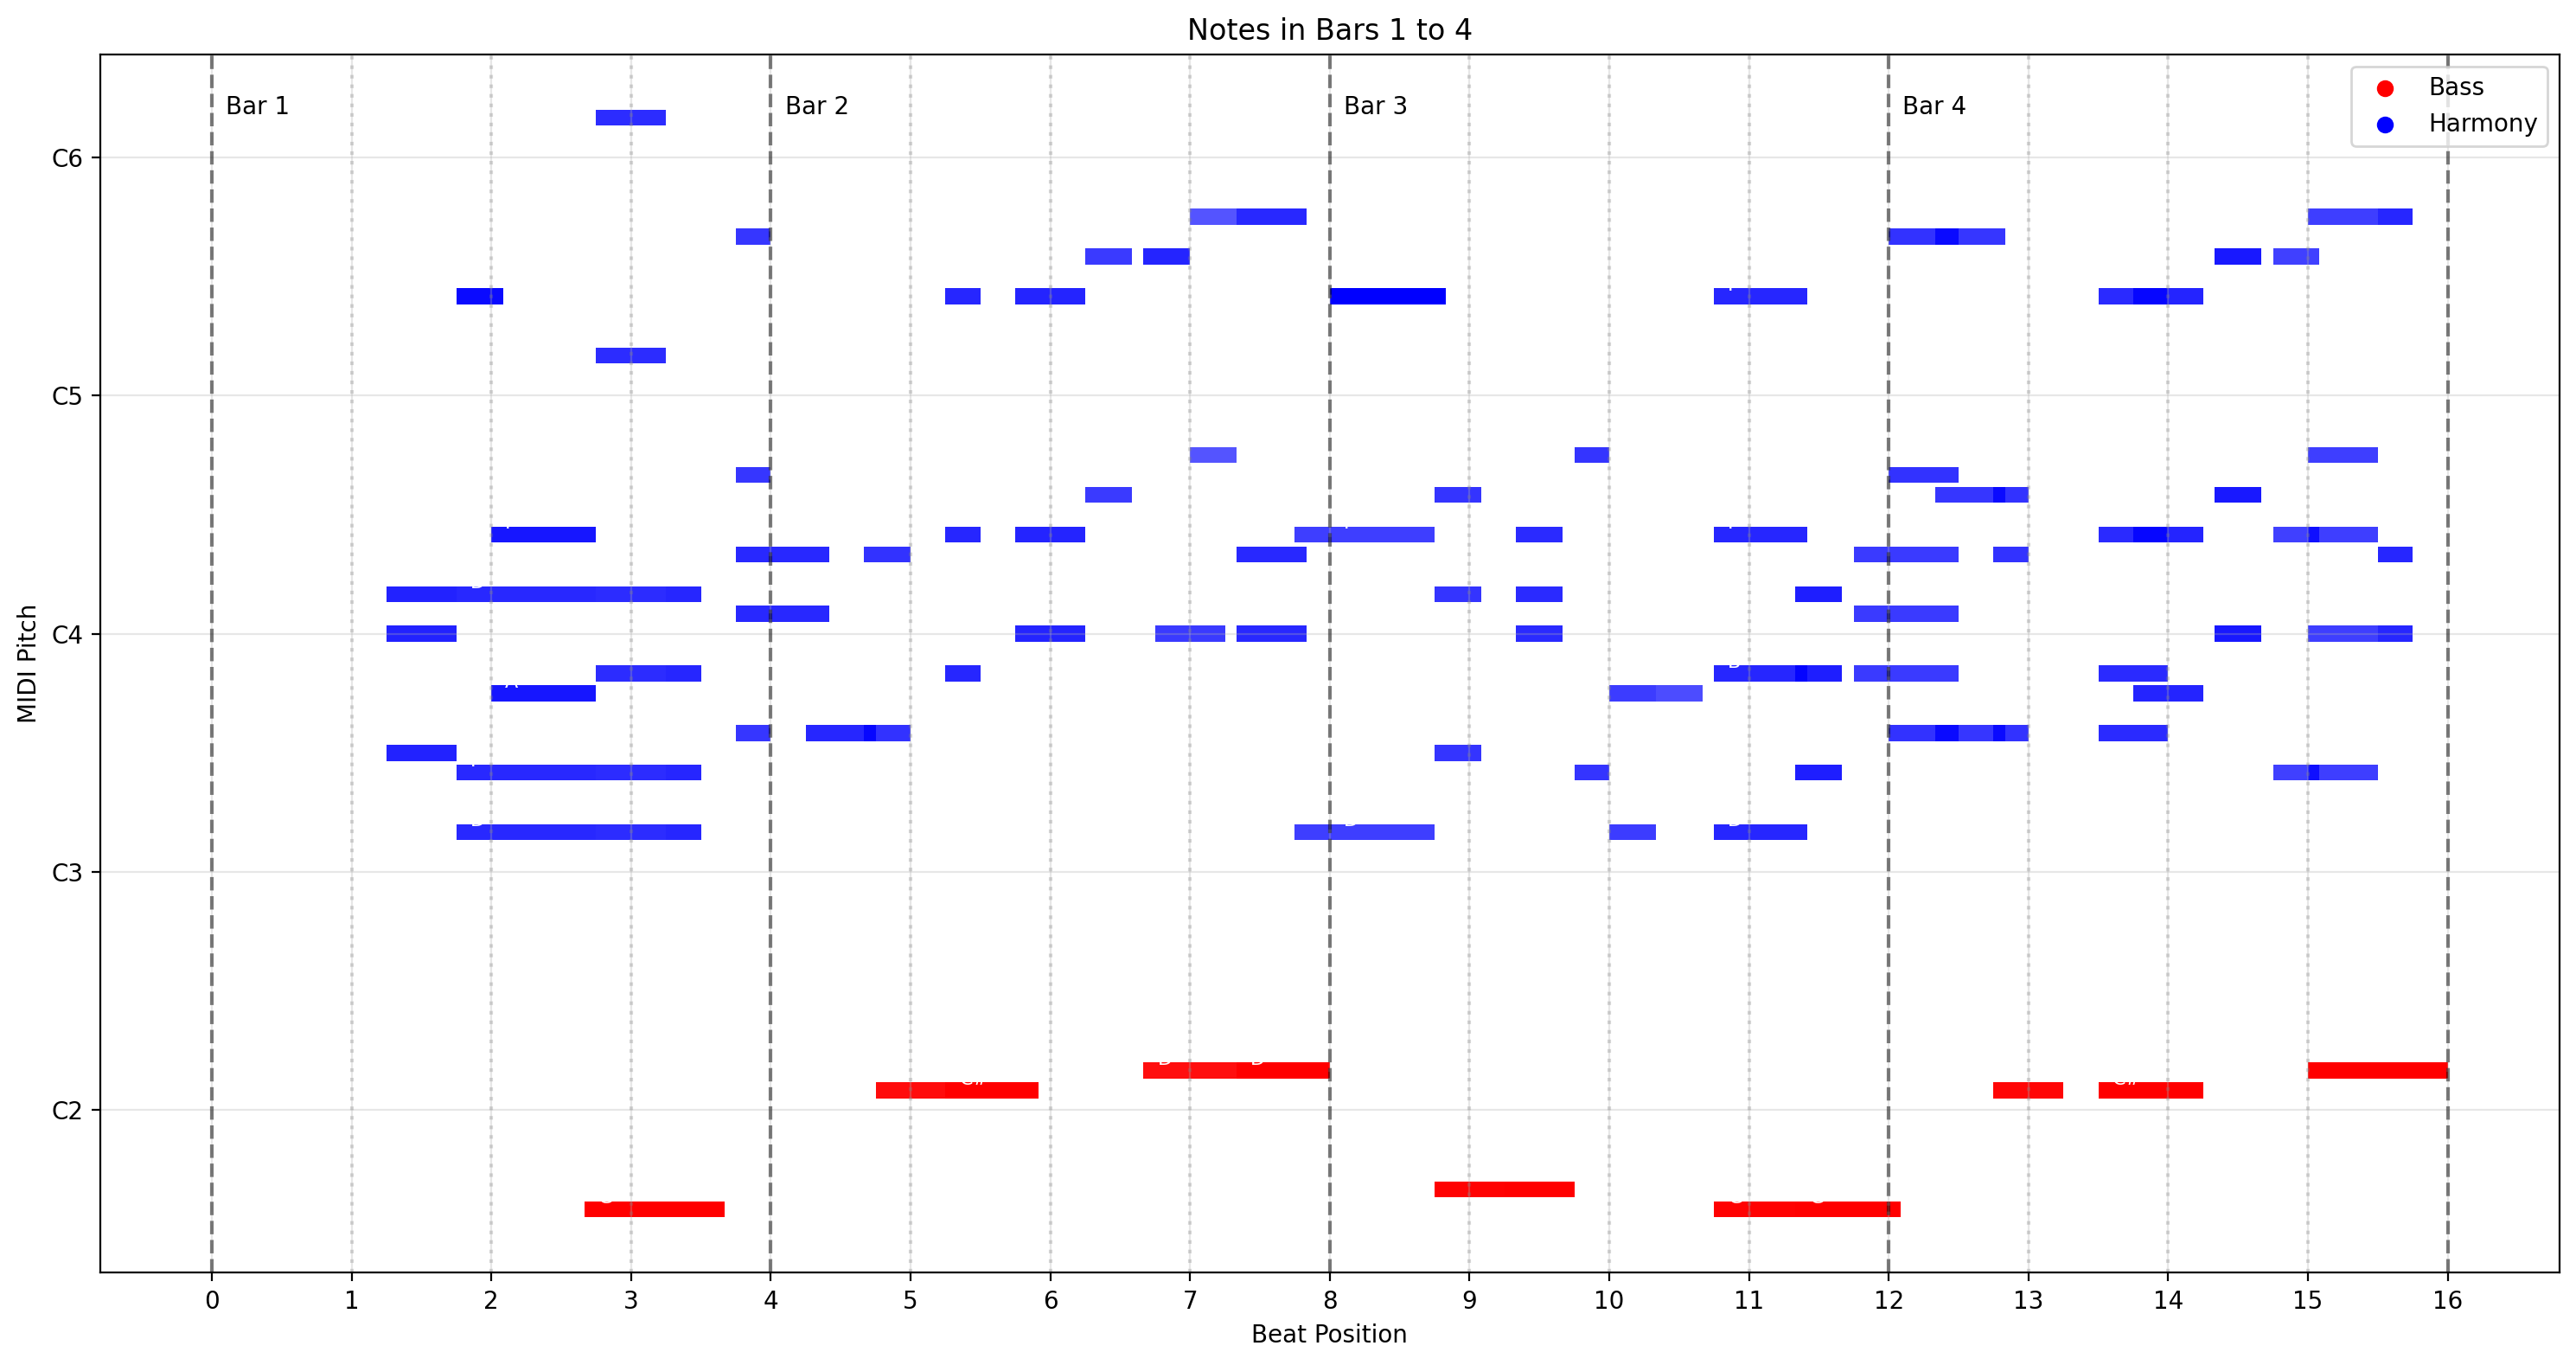


=== Analyzing Bar 1 with Time Windows ===

Bass notes in bar 1:
  Total bass notes: 1
  Significant bass notes (duration >= 0.5): 1
  Bass 1: G (PC 7): 2.67-3.67, duration: 1.00


In [ ]:
from chordAnalyzer import *

# Load notes from the MIDI files
bass_notes = load_midi_notes(bass_midi_path, source_name='bass')
harmony_notes = load_midi_notes(harmony_midi_path, source_name='harmony')

# Combine the notes
combined_notes = bass_notes + harmony_notes
combined_notes.sort(key=lambda x: x['start'])

print(f"Combined {len(bass_notes)} bass notes and {len(harmony_notes)} harmony notes")

# Optional: Add to the end of your existing script
refined_progression = analyze_progression_with_unique_chords(combined_notes, start_bar=0, num_bars=4)

# Cell 9: Analyze the first 4 bars with time-window approach
# print("\n=== Analyzing First 4 Bars with Time Windows ===")
# first_4_bars = analyze_progression_with_time_windows(combined_notes, start_bar=0, num_bars=4)


